In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.base import clone

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression


# Data Loading

In [3]:
# Load data
df = pd.read_csv("/mnt/c/Neuro_Parkinson/data/Cognition_Dataset/OnlyNormalized_volumes(CS).csv")

# Binary labelLing
# Control -> 0, PD-NC & PD-MCI -> 1
df["label"] = df["group"].apply(lambda x: 0 if x == "Control" else 1)

# Drop non-feature columns
X = df.drop(columns=["Subjects", "group", "label"])
y = df["label"]


In [4]:
# Check the number of Healthy and PD-NC(Parkinson's with normal cognition)
df["label"].value_counts()

label
1    33
0    22
Name: count, dtype: int64

# Training models without Feature Selection

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=42
)


In [6]:
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(class_weight="balanced", max_iter=1000))
    ]),

    "SVM (RBF)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel="rbf", probability=True, class_weight="balanced"))
    ]),

    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        class_weight="balanced",
        random_state=42
    ),

    "Decision Tree": DecisionTreeClassifier(
        class_weight="balanced",
        random_state=42
    ),

    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=200,
        random_state=42
    ),

    "KNN": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier(n_neighbors=5))
    ]),

    "Bagging": BaggingClassifier(
        n_estimators=100,
        random_state=42
    )
}


                 Model  Accuracy   ROC-AUC  F1-score
0  Logistic Regression  0.714286  0.604167  0.750000
1            SVM (RBF)  0.928571  0.166667  0.941176
2        Random Forest  0.642857  0.750000  0.705882
3        Decision Tree  0.642857  0.645833  0.666667
4    Gradient Boosting  0.785714  0.916667  0.800000
5                  KNN  0.571429  0.510417  0.625000
6              Bagging  0.785714  0.822917  0.823529


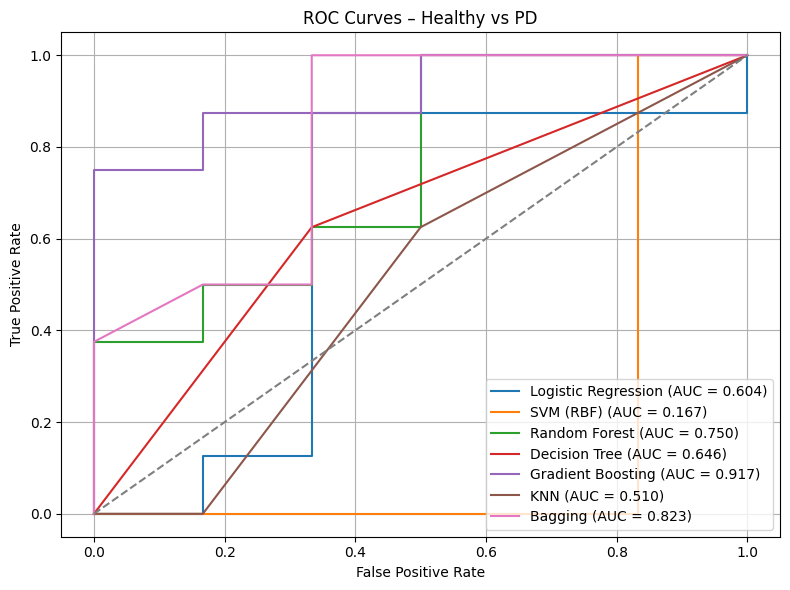

In [7]:
results = []

plt.figure(figsize=(8, 6))

for name, model in models.items():
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)

    results.append({
    "Model": name,
    "Accuracy": accuracy_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_prob),
    "F1-score": f1_score(y_test, y_pred)
    })

    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.3f})")


results_df = pd.DataFrame(results)
print(results_df)


plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Healthy vs PD")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


Voting Classifier Results
Accuracy: 0.7857142857142857
ROC-AUC: 0.625
F1-score: 0.8235294117647058


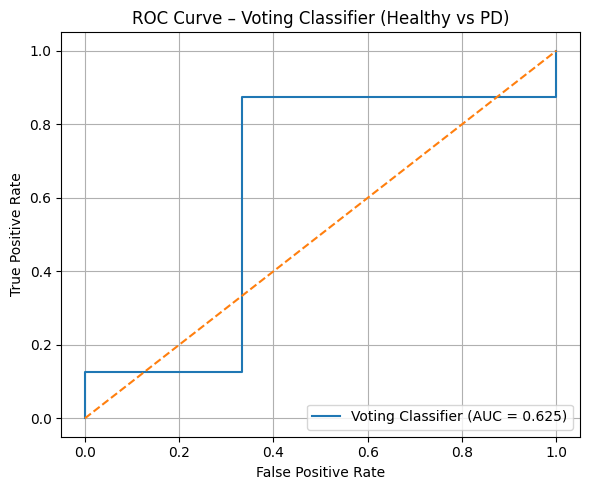

In [8]:
voting_clf = VotingClassifier(
    estimators=[
        ("lr", models["Logistic Regression"]),
        ("rf", models["Random Forest"]),
        ("svm", models["SVM (RBF)"])
    ],
    voting="soft"
)

voting_clf.fit(X_train, y_train)

y_pred = voting_clf.predict(X_test)
y_prob = voting_clf.predict_proba(X_test)[:, 1]

print("Voting Classifier Results")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("F1-score:", f1_score(y_test, y_pred))

fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"Voting Classifier (AUC = {auc_score:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Voting Classifier (Healthy vs PD)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
def evaluate_model(model, model_name, X_test, y_test):
    """
    Prints confusion matrix and classification report
    """
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(4, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["HC", "PD"],
        yticklabels=["HC", "PD"]
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

    print(f"\nClassification Report - {model_name}")
    print(classification_report(
        y_test,
        y_pred,
        target_names=["HC", "PD"]
    ))


Model: Logistic Regression


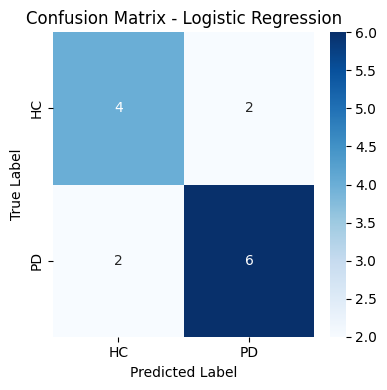


Classification Report - Logistic Regression
              precision    recall  f1-score   support

          HC       0.67      0.67      0.67         6
          PD       0.75      0.75      0.75         8

    accuracy                           0.71        14
   macro avg       0.71      0.71      0.71        14
weighted avg       0.71      0.71      0.71        14

Model: SVM (RBF)


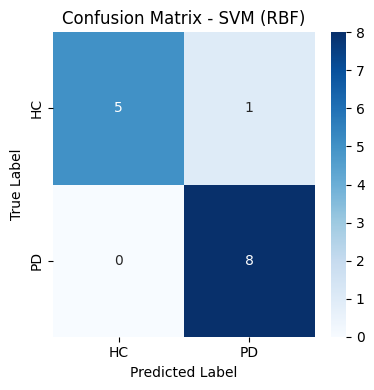


Classification Report - SVM (RBF)
              precision    recall  f1-score   support

          HC       1.00      0.83      0.91         6
          PD       0.89      1.00      0.94         8

    accuracy                           0.93        14
   macro avg       0.94      0.92      0.93        14
weighted avg       0.94      0.93      0.93        14

Model: Random Forest


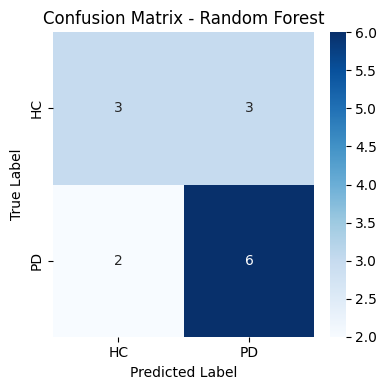


Classification Report - Random Forest
              precision    recall  f1-score   support

          HC       0.60      0.50      0.55         6
          PD       0.67      0.75      0.71         8

    accuracy                           0.64        14
   macro avg       0.63      0.62      0.63        14
weighted avg       0.64      0.64      0.64        14

Model: Decision Tree


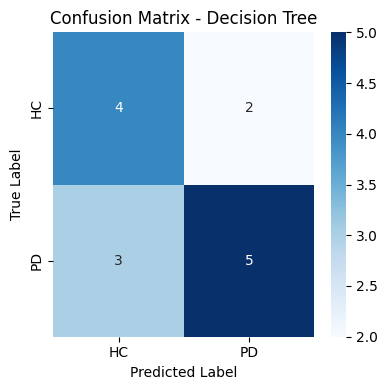


Classification Report - Decision Tree
              precision    recall  f1-score   support

          HC       0.57      0.67      0.62         6
          PD       0.71      0.62      0.67         8

    accuracy                           0.64        14
   macro avg       0.64      0.65      0.64        14
weighted avg       0.65      0.64      0.64        14

Model: Gradient Boosting


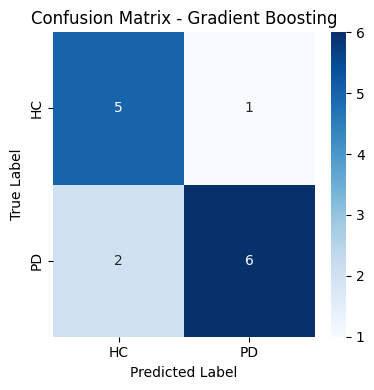


Classification Report - Gradient Boosting
              precision    recall  f1-score   support

          HC       0.71      0.83      0.77         6
          PD       0.86      0.75      0.80         8

    accuracy                           0.79        14
   macro avg       0.79      0.79      0.78        14
weighted avg       0.80      0.79      0.79        14

Model: KNN


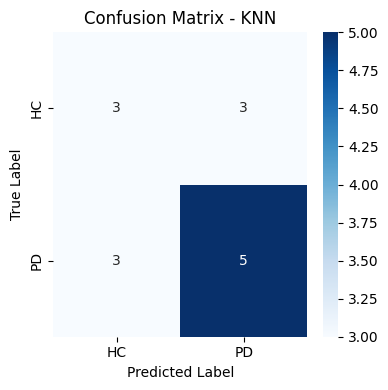


Classification Report - KNN
              precision    recall  f1-score   support

          HC       0.50      0.50      0.50         6
          PD       0.62      0.62      0.62         8

    accuracy                           0.57        14
   macro avg       0.56      0.56      0.56        14
weighted avg       0.57      0.57      0.57        14

Model: Bagging


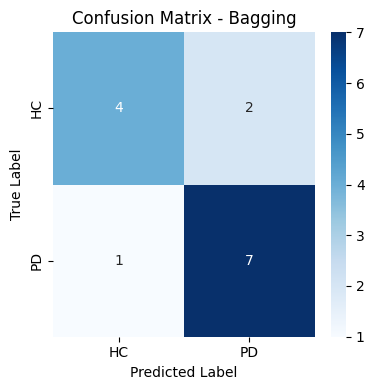


Classification Report - Bagging
              precision    recall  f1-score   support

          HC       0.80      0.67      0.73         6
          PD       0.78      0.88      0.82         8

    accuracy                           0.79        14
   macro avg       0.79      0.77      0.78        14
weighted avg       0.79      0.79      0.78        14



In [10]:
for name, model in models.items():
    print("=" * 60)
    print(f"Model: {name}")

    model.fit(X_train, y_train)
    evaluate_model(model, name, X_test, y_test)


# Feature Selection

In [11]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("selector", SelectKBest(score_func=f_classif, k=10)),
    ("clf", LogisticRegression(class_weight="balanced", max_iter=1000))
])

pipe.fit(X_train, y_train)


/home/barsha/envs/jupyter/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [36 37 38 39 40] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/barsha/envs/jupyter/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


,steps,"[('scaler', ...), ('selector', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,score_func,<function f_c...x703fa911cf70>
,k,10
,penalty,'l2'
,dual,False


In [12]:
selected_features_LR = X.columns[pipe.named_steps["selector"].get_support()]
print(selected_features_LR)


Index(['Unnamed: 0', 'norm_Brain-Stem', 'norm_Left-Amygdala', 'norm_CSF',
       'norm_Left-choroid-plexus', 'norm_Right-Accumbens-area',
       'norm_5th-Ventricle', 'norm_lhCerebralWhiteMatterVol',
       'norm_rhCerebralWhiteMatterVol', 'norm_CerebralWhiteMatterVol'],
      dtype='object')


In [13]:
## Embedded methods (L1-regularized Logistic Regression)
pipe_l1 = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        penalty="l1",
        solver="liblinear",
        class_weight="balanced",
        max_iter=1000
    ))
])

pipe_l1.fit(X_train, y_train)


,steps,"[('scaler', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l1'
,dual,False
,tol,0.0001
,C,1.0


In [14]:
coef = pipe_l1.named_steps["clf"].coef_[0]
selected_features_LASSO = X.columns[coef != 0]

print("Selected features:", selected_features_LASSO)


Selected features: Index(['Unnamed: 0', 'age', 'norm_Left-Putamen', 'norm_3rd-Ventricle',
       'norm_Brain-Stem', 'norm_Left-Amygdala', 'norm_CSF',
       'norm_Right-Inf-Lat-Vent', 'norm_Right-Cerebellum-White-Matter',
       'norm_Right-Cerebellum-Cortex', 'norm_Right-Thalamus',
       'norm_Right-Hippocampus', 'norm_Right-Accumbens-area',
       'norm_Right-VentralDC', 'norm_Right-vessel', 'norm_5th-Ventricle',
       'norm_rhCerebralWhiteMatterVol'],
      dtype='object')


In [15]:
# Tree-based feature importance 

rf = RandomForestClassifier(
    n_estimators=500,
    class_weight="balanced",
    random_state=42
)

rf.fit(X_train, y_train)

importances = pd.Series(rf.feature_importances_, index=X.columns)
SELECTED_FEATURES_RF = importances.sort_values(ascending=False).head(10)
SELECTED_FEATURES_RF

Unnamed: 0                      0.078535
norm_Left-Amygdala              0.030267
norm_5th-Ventricle              0.029218
norm_CSF                        0.027779
norm_Brain-Stem                 0.027427
norm_Optic-Chiasm               0.026119
norm_SubCortGrayVol             0.024460
norm_CC_Mid_Posterior           0.023940
norm_Right-Cerebellum-Cortex    0.022422
norm_3rd-Ventricle              0.021635
dtype: float64

In [16]:
# Wrapper methods 

from sklearn.feature_selection import RFE

rfe = RFE(
    estimator=LogisticRegression(
        class_weight="balanced",
        max_iter=500
    ),
    n_features_to_select=10
)

rfe.fit(X_train, y_train)

selected_features_RFE = X.columns[rfe.support_]
print(selected_features_RFE)


/home/barsha/envs/jupyter/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/barsha/envs/jupyter/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preproces

Index(['age', 'norm_Left-Inf-Lat-Vent', 'norm_Left-Pallidum', 'norm_CSF',
       'norm_Left-Accumbens-area', 'norm_Right-Thalamus',
       'norm_Right-Accumbens-area', 'norm_CC_Mid_Posterior', 'norm_CC_Central',
       'norm_CC_Mid_Anterior'],
      dtype='object')


/home/barsha/envs/jupyter/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/barsha/envs/jupyter/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preproces

In [17]:

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("selector", SelectKBest(f_classif, k=10)),
    ("clf", SVC(kernel="rbf", probability=True, class_weight="balanced"))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    pipe,
    X,
    y,
    cv=cv,
    scoring="roc_auc"
)

print("Mean ROC-AUC:", scores.mean())


/home/barsha/envs/jupyter/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [36 37 38 39 40] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/barsha/envs/jupyter/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/home/barsha/envs/jupyter/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [36 37 38 39 40] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/barsha/envs/jupyter/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/home/barsha/envs/jupyter/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [36 37 38 39 40] 

Mean ROC-AUC: 0.6461904761904761


/home/barsha/envs/jupyter/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [36 37 38 39 40] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/barsha/envs/jupyter/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [18]:
selected_features_rfe = selected_features_RFE.tolist()
selected_features_lasso = selected_features_LASSO.tolist()
selected_features_lr = selected_features_LR.tolist()
selected_features_rf = SELECTED_FEATURES_RF.index.tolist()


type(selected_features_rfe), type(selected_features_lasso), type(selected_features_lr), type(selected_features_rf)

final_selected_features = selected_features_rfe + selected_features_lasso + selected_features_lr + selected_features_rf 
final_selected_features = set(final_selected_features)
# final_selected_features.remove("Unnamed: 0")

final_selected_features

{'Unnamed: 0',
 'age',
 'norm_3rd-Ventricle',
 'norm_5th-Ventricle',
 'norm_Brain-Stem',
 'norm_CC_Central',
 'norm_CC_Mid_Anterior',
 'norm_CC_Mid_Posterior',
 'norm_CSF',
 'norm_CerebralWhiteMatterVol',
 'norm_Left-Accumbens-area',
 'norm_Left-Amygdala',
 'norm_Left-Inf-Lat-Vent',
 'norm_Left-Pallidum',
 'norm_Left-Putamen',
 'norm_Left-choroid-plexus',
 'norm_Optic-Chiasm',
 'norm_Right-Accumbens-area',
 'norm_Right-Cerebellum-Cortex',
 'norm_Right-Cerebellum-White-Matter',
 'norm_Right-Hippocampus',
 'norm_Right-Inf-Lat-Vent',
 'norm_Right-Thalamus',
 'norm_Right-VentralDC',
 'norm_Right-vessel',
 'norm_SubCortGrayVol',
 'norm_lhCerebralWhiteMatterVol',
 'norm_rhCerebralWhiteMatterVol'}

In [19]:
df_list = df.columns.values.tolist()
len(df_list)
drop_features = set(df_list) - set(final_selected_features)
len(drop_features), len(final_selected_features), len(df_list)

(35, 28, 63)

In [20]:
drop_features

{'Subjects',
 'group',
 'label',
 'norm_4th-Ventricle',
 'norm_BrainSegVol',
 'norm_BrainSegVolNotVent',
 'norm_CC_Anterior',
 'norm_CC_Posterior',
 'norm_CortexVol',
 'norm_Left-Caudate',
 'norm_Left-Cerebellum-Cortex',
 'norm_Left-Cerebellum-White-Matter',
 'norm_Left-Hippocampus',
 'norm_Left-Lateral-Ventricle',
 'norm_Left-Thalamus',
 'norm_Left-VentralDC',
 'norm_Left-WM-hypointensities',
 'norm_Left-non-WM-hypointensities',
 'norm_Left-vessel',
 'norm_MaskVol',
 'norm_Right-Amygdala',
 'norm_Right-Caudate',
 'norm_Right-Lateral-Ventricle',
 'norm_Right-Pallidum',
 'norm_Right-Putamen',
 'norm_Right-WM-hypointensities',
 'norm_Right-choroid-plexus',
 'norm_Right-non-WM-hypointensities',
 'norm_SupraTentorialVol',
 'norm_SupraTentorialVolNotVent',
 'norm_TotalGrayVol',
 'norm_WM-hypointensities',
 'norm_lhCortexVol',
 'norm_non-WM-hypointensities',
 'norm_rhCortexVol'}

# Training models with  the selected features

In [21]:
# Drop the columns not in drop_features list
X = df.drop(columns=['Subjects','group','label','norm_4th-Ventricle','norm_BrainSegVol','norm_BrainSegVolNotVent','norm_CC_Anterior',
                     'norm_CC_Posterior','norm_CortexVol','norm_Left-Caudate','norm_Left-Cerebellum-Cortex','norm_Left-Cerebellum-White-Matter',
                     'norm_Left-Hippocampus','norm_Left-Lateral-Ventricle','norm_Left-Thalamus','norm_Left-VentralDC',
                     'norm_Left-WM-hypointensities','norm_Left-non-WM-hypointensities','norm_Left-vessel','norm_MaskVol','norm_Right-Amygdala',
                     'norm_Right-Caudate','norm_Right-Lateral-Ventricle','norm_Right-Pallidum','norm_Right-Putamen',
                     'norm_Right-WM-hypointensities','norm_Right-choroid-plexus','norm_Right-non-WM-hypointensities','norm_SupraTentorialVol',
                     'norm_SupraTentorialVolNotVent','norm_TotalGrayVol','norm_WM-hypointensities','norm_lhCortexVol',
                     'norm_non-WM-hypointensities','norm_rhCortexVol'])
y = df["label"]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=42
)


In [23]:
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(class_weight="balanced", max_iter=1000))
    ]),

    "SVM (RBF)": Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", probability=True, class_weight="balanced"))
    ]),

    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        class_weight="balanced",
        random_state=42
    ),

    "Decision Tree": DecisionTreeClassifier(
        class_weight="balanced",
        random_state=42
    ),

    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=200,
        random_state=42
    ),

    "KNN": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier(n_neighbors=5))
    ]),

    "Bagging": BaggingClassifier(
        n_estimators=100,
        random_state=42
    )
}


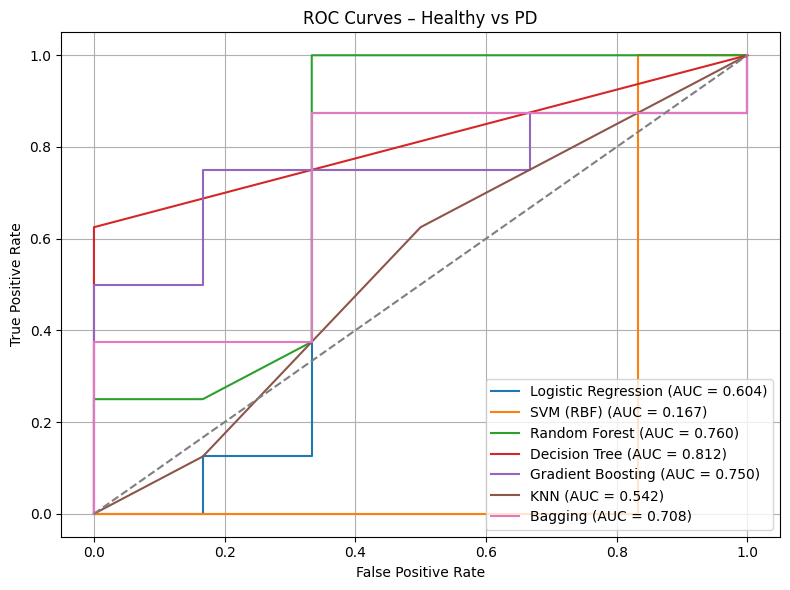

In [24]:
results = []

plt.figure(figsize=(8, 6))

for name, model in models.items():
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)

    results.append({
    "Model": name,
    "Accuracy": accuracy_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_prob),
    "F1-score": f1_score(y_test, y_pred)
    })

    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.3f})")


results_df = pd.DataFrame(results)


plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Healthy vs PD")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


Voting Classifier Results
Accuracy: 0.6428571428571429
ROC-AUC: 0.6875
F1-score: 0.6666666666666666


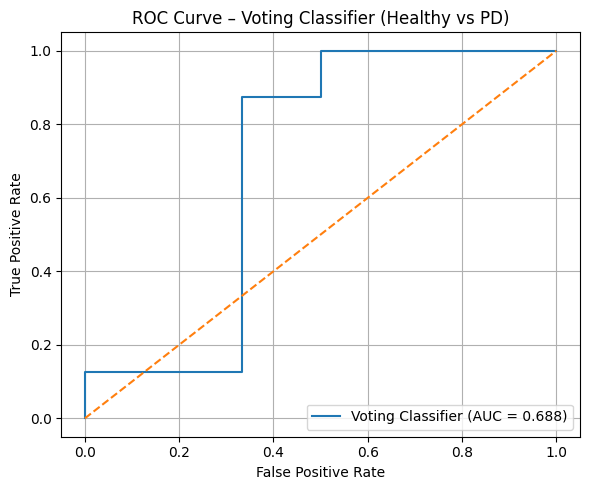

In [25]:
voting_clf = VotingClassifier(
    estimators=[
        ("lr", models["Logistic Regression"]),
        ("rf", models["Random Forest"]),
        ("svm", models["SVM (RBF)"])
    ],
    voting="soft"
)

voting_clf.fit(X_train, y_train)

y_pred = voting_clf.predict(X_test)
y_prob = voting_clf.predict_proba(X_test)[:, 1]

print("Voting Classifier Results")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("F1-score:", f1_score(y_test, y_pred))

# Get ROC values
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"Voting Classifier (AUC = {auc_score:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Voting Classifier (Healthy vs PD)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


Model: Logistic Regression


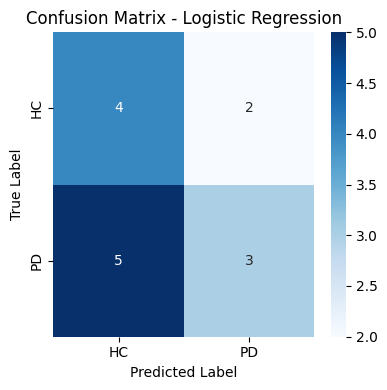


Classification Report - Logistic Regression
              precision    recall  f1-score   support

          HC       0.44      0.67      0.53         6
          PD       0.60      0.38      0.46         8

    accuracy                           0.50        14
   macro avg       0.52      0.52      0.50        14
weighted avg       0.53      0.50      0.49        14

Model: SVM (RBF)


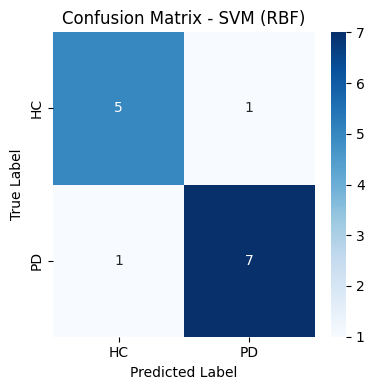


Classification Report - SVM (RBF)
              precision    recall  f1-score   support

          HC       0.83      0.83      0.83         6
          PD       0.88      0.88      0.88         8

    accuracy                           0.86        14
   macro avg       0.85      0.85      0.85        14
weighted avg       0.86      0.86      0.86        14

Model: Random Forest


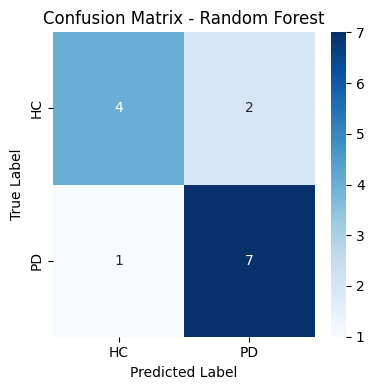


Classification Report - Random Forest
              precision    recall  f1-score   support

          HC       0.80      0.67      0.73         6
          PD       0.78      0.88      0.82         8

    accuracy                           0.79        14
   macro avg       0.79      0.77      0.78        14
weighted avg       0.79      0.79      0.78        14

Model: Decision Tree


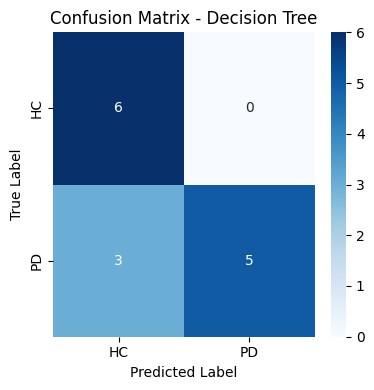


Classification Report - Decision Tree
              precision    recall  f1-score   support

          HC       0.67      1.00      0.80         6
          PD       1.00      0.62      0.77         8

    accuracy                           0.79        14
   macro avg       0.83      0.81      0.78        14
weighted avg       0.86      0.79      0.78        14

Model: Gradient Boosting


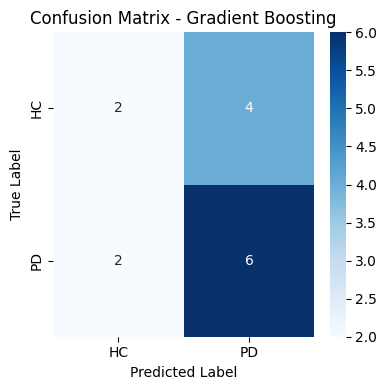


Classification Report - Gradient Boosting
              precision    recall  f1-score   support

          HC       0.50      0.33      0.40         6
          PD       0.60      0.75      0.67         8

    accuracy                           0.57        14
   macro avg       0.55      0.54      0.53        14
weighted avg       0.56      0.57      0.55        14

Model: KNN


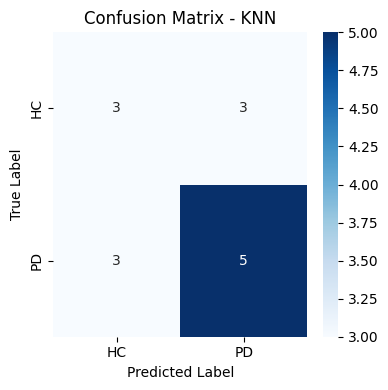


Classification Report - KNN
              precision    recall  f1-score   support

          HC       0.50      0.50      0.50         6
          PD       0.62      0.62      0.62         8

    accuracy                           0.57        14
   macro avg       0.56      0.56      0.56        14
weighted avg       0.57      0.57      0.57        14

Model: Bagging


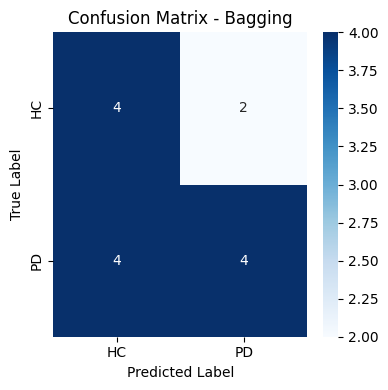


Classification Report - Bagging
              precision    recall  f1-score   support

          HC       0.50      0.67      0.57         6
          PD       0.67      0.50      0.57         8

    accuracy                           0.57        14
   macro avg       0.58      0.58      0.57        14
weighted avg       0.60      0.57      0.57        14



In [26]:
def evaluate_model(model, model_name, X_test, y_test):
    """
    Prints confusion matrix and classification report
    """
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(4, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["HC", "PD"],
        yticklabels=["HC", "PD"]
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

    print(f"\nClassification Report - {model_name}")
    print(classification_report(
        y_test,
        y_pred,
        target_names=["HC", "PD"]
    ))

for name, model in models.items():
    print("=" * 60)
    print(f"Model: {name}")

    model.fit(X_train, y_train)
    evaluate_model(model, name, X_test, y_test)


Mean AUC score : 0.7133333333333333


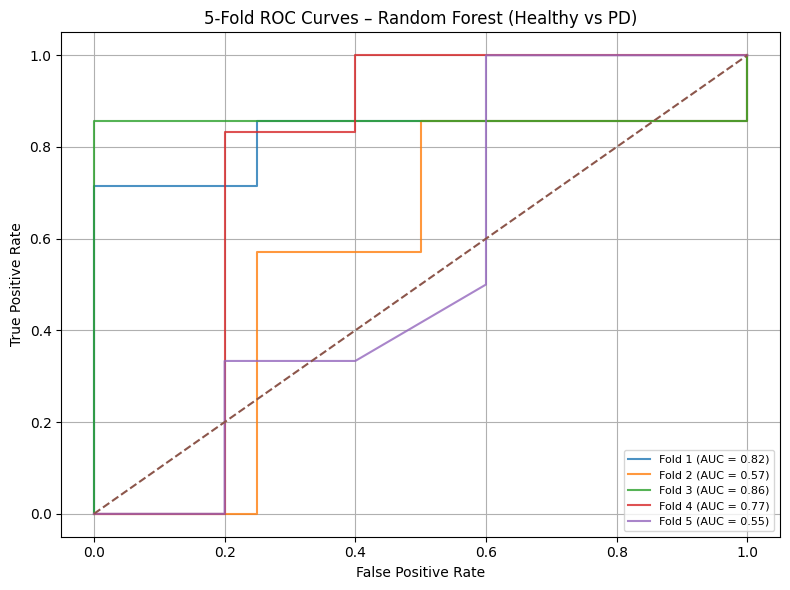

In [27]:
# Random  Forest

plt.figure(figsize=(8, 6))

aucs_RF = []

for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]


    model = models["Random Forest"]
    model.fit(X_train_cv, y_train_cv)

    y_prob = model.predict_proba(X_test_cv)[:, 1]

    fpr, tpr, _ = roc_curve(y_test_cv, y_prob)
    auc = roc_auc_score(y_test_cv, y_prob)
    aucs_RF.append(auc)

    plt.plot(
        fpr,
        tpr,
        lw=1.5,
        alpha=0.8,
        label=f"Fold {fold} (AUC = {auc:.2f})"
    )

print("Mean AUC score :", np.mean(aucs_RF))

plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("5-Fold ROC Curves – Random Forest (Healthy vs PD)")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


Mean AUC score : 0.8554761904761904


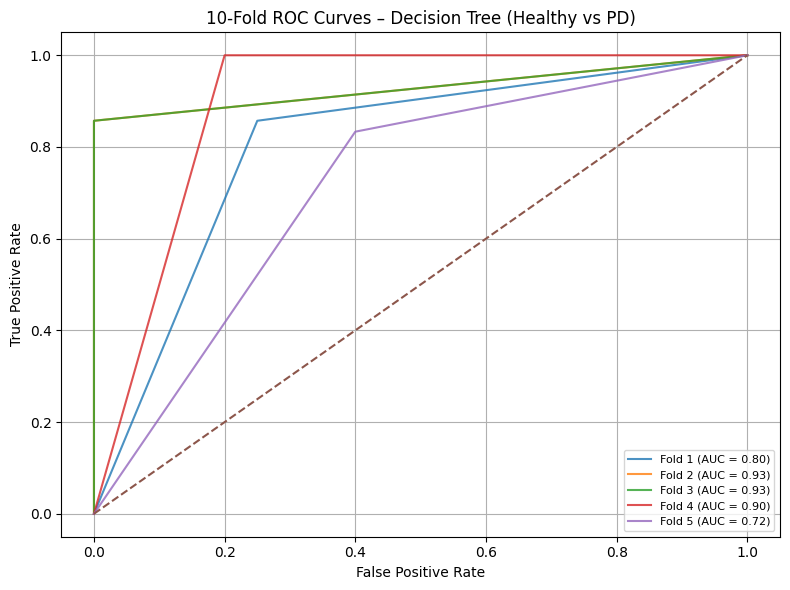

In [28]:
# Decision Tree

plt.figure(figsize=(8, 6))

aucs_DT = []

for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]


    model = models["Decision Tree"]
    model.fit(X_train_cv, y_train_cv)

    y_prob = model.predict_proba(X_test_cv)[:, 1]

    fpr, tpr, _ = roc_curve(y_test_cv, y_prob)
    auc = roc_auc_score(y_test_cv, y_prob)
    aucs_DT.append(auc)

    plt.plot(
        fpr,
        tpr,
        lw=1.5,
        alpha=0.8,
        label=f"Fold {fold} (AUC = {auc:.2f})"
    )

print("Mean AUC score :", np.mean(aucs_DT))
plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("10-Fold ROC Curves – Decision Tree (Healthy vs PD)")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


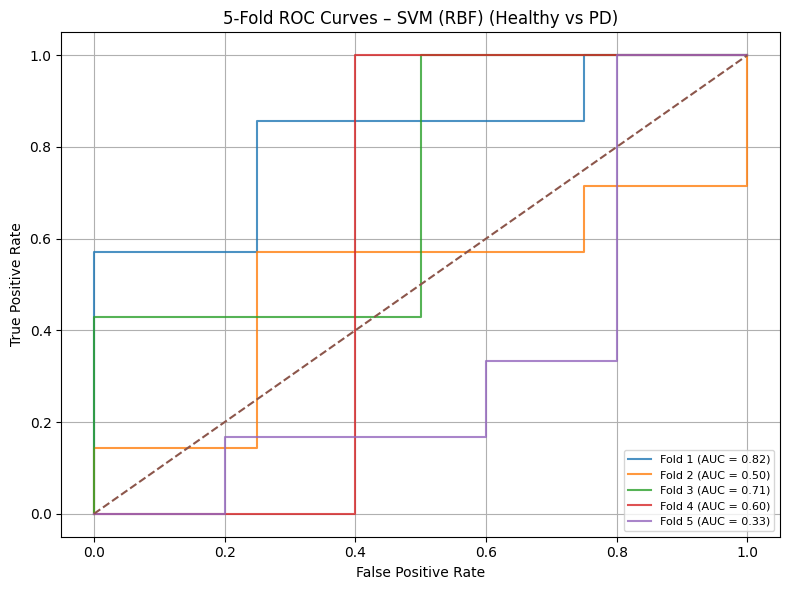

In [29]:
plt.figure(figsize=(8, 6))

aucs_SVM = []

for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]


    model = models["SVM (RBF)"]
    model.fit(X_train_cv, y_train_cv)

    y_prob = model.predict_proba(X_test_cv)[:, 1]

    fpr, tpr, _ = roc_curve(y_test_cv, y_prob)
    auc = roc_auc_score(y_test_cv, y_prob)
    aucs_SVM.append(auc)

    plt.plot(
        fpr,
        tpr,
        lw=1.5,
        alpha=0.8,
        label=f"Fold {fold} (AUC = {auc:.2f})"
    )


plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("5-Fold ROC Curves – SVM (RBF) (Healthy vs PD)")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
print("Mean AUC score :", np.mean(aucs_SVM))

In [ ]:
# Gradient Boosting

plt.figure(figsize=(8, 6))

aucs_GB = []

for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]

    model = models["Gradient Boosting"]
    model.fit(X_train_cv, y_train_cv)

    y_prob = model.predict_proba(X_test_cv)[:, 1]

    fpr, tpr, _ = roc_curve(y_test_cv, y_prob)
    auc = roc_auc_score(y_test_cv, y_prob)
    aucs_GB.append(auc)

    plt.plot(
        fpr,
        tpr,
        lw=1.5,
        alpha=0.8,
        label=f"Fold {fold} (AUC = {auc:.2f})"
    )


plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("5-Fold ROC Curves – Gradient Boosting (Healthy vs PD)")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
print("Mean AUC score :", np.mean(aucs_GB))

In [ ]:
plt.figure(figsize=(8, 6))

aucs_knn = []

for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]


    model = models["KNN"]
    model.fit(X_train_cv, y_train_cv)

    y_prob = model.predict_proba(X_test_cv)[:, 1]

    fpr, tpr, _ = roc_curve(y_test_cv, y_prob)
    auc = roc_auc_score(y_test_cv, y_prob)
    aucs_knn.append(auc)

    plt.plot(
        fpr,
        tpr,
        lw=1.5,
        alpha=0.8,
        label=f"Fold {fold} (AUC = {auc:.2f})"
    )


plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("5-Fold ROC Curves – KNN (Healthy vs PD)")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
print("Mean AUC score :", np.mean(aucs_knn))

In [ ]:
# Bagging

plt.figure(figsize=(8, 6))

aucs_bagging = []

for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]


    model = models["Bagging"]
    model.fit(X_train_cv, y_train_cv)

    y_prob = model.predict_proba(X_test_cv)[:, 1]

    fpr, tpr, _ = roc_curve(y_test_cv, y_prob)
    auc = roc_auc_score(y_test_cv, y_prob)
    aucs_bagging.append(auc)

    plt.plot(
        fpr,
        tpr,
        lw=1.5,
        alpha=0.8,
        label=f"Fold {fold} (AUC = {auc:.2f})"
    )


plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("5-Fold ROC Curves – Bagging (Healthy vs PD)")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
print("Mean AUC score :", np.mean(aucs_bagging))

In [ ]:

# Voting Classifier

plt.figure(figsize=(8, 6))

aucs = []

for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]

    # IMPORTANT: clone to avoid information leakage
    model = clone(voting_clf)
    model.fit(X_train_cv, y_train_cv)

    y_prob = model.predict_proba(X_test_cv)[:, 1]

    fpr, tpr, _ = roc_curve(y_test_cv, y_prob)
    auc = roc_auc_score(y_test_cv, y_prob)
    aucs.append(auc)

    plt.plot(
        fpr,
        tpr,
        lw=1.5,
        alpha=0.8,
        label=f"Fold {fold} (AUC = {auc:.2f})"
    )


plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Stratified 5-Fold ROC Curves – Voting Classifier")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
print("Mean AUC score :", np.mean(aucs))